<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

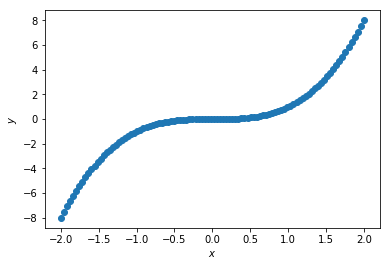

In [2]:
X = np.linspace(-2, 2, 100)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

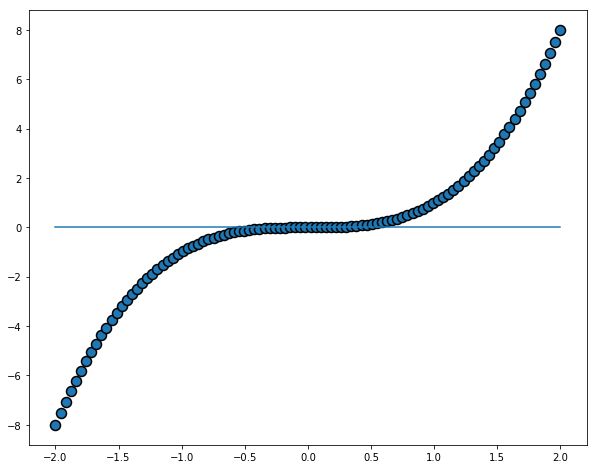

In [3]:
# Ваш код здесь
def a(x):
    return X.mean()
a = np.vectorize(a)

predictions = a(X)
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(X, y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(X, predictions);

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

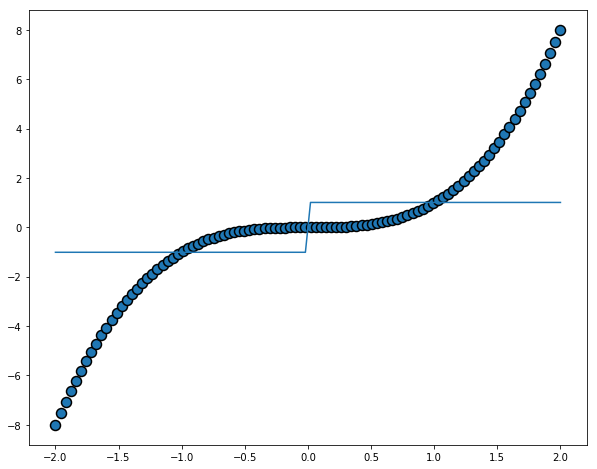

In [4]:
# Ваш код здесь
def a(x,t):
    if(x<t):
        return X[X<t].mean()
    else:
        return X[X>=t].mean()
    
a = np.vectorize(a)

predictions = a(X,0)
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(X, y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(X, predictions);

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [7]:
def M(values, t):
    return np.sum(a(values, t))/values.size

def D(values, t):
    return M((a(values, t)-M(values, t))**2, t)

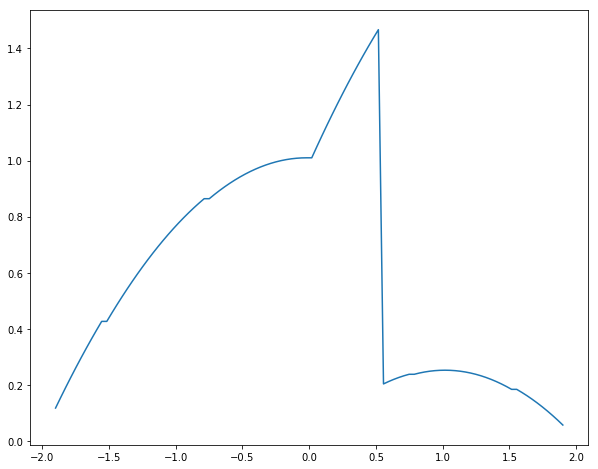

In [8]:
# Ваш код здесь
def regression_var_criterion(t):
    return D(X,t) - (X[X<t].size*D(X[X<t],t) - X[X>=t].size*D(X[X>=t],t))/X.size
regression_var_criterion = np.vectorize(regression_var_criterion)
T = np.linspace(-1.9, 1.9, 100)
#regression_var_criterion(X_s,0.3)
Q = regression_var_criterion(T)
plt.plot(T, Q);

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

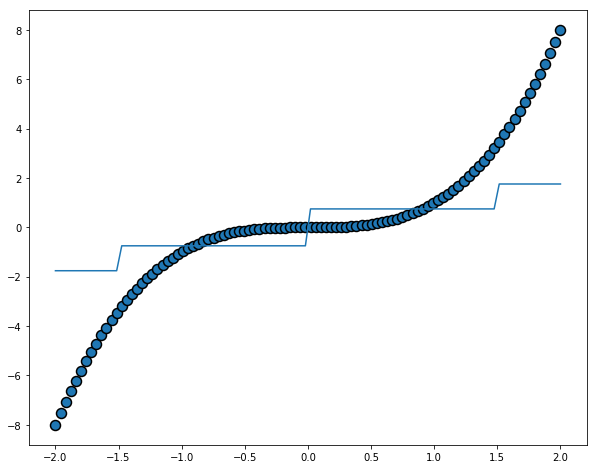

In [9]:
# Ваш код здесь
def f(x):
    if(x<0):
        if(x<-1.5):
            return X[(X<0) & (X<-1.5)].mean()
        else:
            return X[(X<0) & (X>=-1.5)].mean()
    else:
        if(x<1.5):
            return X[(X>=0) & (X<1.5)].mean()
        else:
            return X[(X>=0) & (X>=1.5)].mean()
        
f = np.vectorize(f)

predictions = f(X)
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(X, y, s=100, cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(X, predictions);

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [10]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [11]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [12]:
# Ваш код здесь
df['age_years'] = (df['age'] // 365.25).astype(int)
dum = pd.get_dummies(data=df, columns=['cholesterol', 'gluc'])
dum.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,1,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [13]:
values = dum.cardio.values
dum.drop('cardio', axis=1, inplace=True)
X_train, X_valid, y_train, y_valid = train_test_split(dum, values, test_size=0.3, random_state=17)
dum

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,47,1,0,0,1,0,0
8,21914,1,151,67.0,120,80,0,0,0,59,0,1,0,0,1,0
9,22113,1,157,93.0,130,80,0,0,1,60,0,0,1,1,0,0
12,22584,2,178,95.0,130,90,0,0,1,61,0,0,1,0,0,1
13,17668,1,158,71.0,110,70,0,0,1,48,1,0,0,1,0,0


Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [14]:
# Ваш код здесь
from sklearn.tree import DecisionTreeClassifier
import pydot
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

clf_tree.fit(X_train, y_train)
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=X_train.columns.values, 
out_file='../../img/small_tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
#dot_graph = pydot.graph_from_dot_file('../../img/small_tree.dot')
#!pip install pydot
!dot -Tpng "../../img/small_tree.dot" -o "../../img/small_tree.png"

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [77]:
# Ваш код здесь
predictions = clf_tree.predict(X_valid)
print(predictions)
print(y_valid)
from sklearn.metrics import accuracy_score
accuracy_score(y_valid,predictions)

[0 0 1 ..., 1 1 1]
[0 0 0 ..., 1 1 1]


0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [78]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(clf_tree, tree_params, cv=5)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

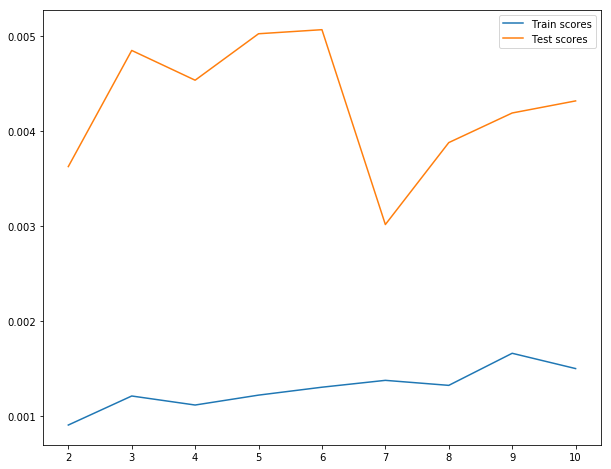

In [79]:
# Ваш код здесь
params = tree_grid.cv_results_['params']
params = [p['max_depth'] for p in params]

std_test_score = tree_grid.cv_results_['std_test_score']
std_train_score = tree_grid.cv_results_['std_train_score']

line_train_scores, = plt.plot(params, std_train_score)
line_test_scores, = plt.plot(params, std_test_score)
plt.legend([line_train_scores, line_test_scores],['Train scores','Test scores'])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [84]:
# Ваш код здесь
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=17)

clf_tree.fit(X_train, y_train)
predictions = clf_tree.predict(X_valid)
print(predictions)
print(y_valid)
from sklearn.metrics import accuracy_score
last_accuracy = 0.72128571428571431
current_accuracy = accuracy_score(y_valid,predictions)
percentage = (current_accuracy-last_accuracy)*100/last_accuracy
print(percentage)

[0 0 1 ..., 1 0 1]
[0 0 0 ..., 1 1 1]
0.699808542946


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [116]:
# Ваш код здесь
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')
df.head()
df['age_years'] = (df['age'] // 365.25).astype(int)
df = pd.get_dummies(data=df, columns=['cholesterol'])
df.head()
df['age_45_50'] = ((df['age_years']>=45) & (df['age_years']<50)).astype(int)
df['age_50_55'] = ((df['age_years']>=50) & (df['age_years']<55)).astype(int)
df['age_55_60'] = ((df['age_years']>=55) & (df['age_years']<60)).astype(int)
df['age_65_65'] = ((df['age_years']>=60) & (df['age_years']<65)).astype(int)
df['ap_hi_120_140'] = ((df['ap_hi']>=120) & (df['ap_hi']<140)).astype(int)
df['ap_hi_140_160'] = ((df['ap_hi']>=140) & (df['ap_hi']<160)).astype(int)
df['ap_hi_160_180'] = ((df['ap_hi']>=160) & (df['ap_hi']<180)).astype(int)

df = df.drop(['age','height','weight','gluc','ap_lo','ap_hi'], axis=1)

df.head()

values = df.cardio.values
df.drop('cardio', axis=1, inplace=True)

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

clf_tree.fit(df, values)
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=df.columns.values, 
out_file='../../img/tree.dot', filled=True)
# для этого понадобится библиотека pydot (pip install pydot)
#dot_graph = pydot.graph_from_dot_file('../../img/small_tree.dot')
#!pip install pydot
!dot -Tpng "../../img/tree.dot" -o "../../img/tree.png"